<a href="https://colab.research.google.com/github/moni6264/deeplearning2/blob/main/CNN_PartB(xception).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
zip_path = "drive/MyDrive/nature_12K.zip"
!cp "{zip_path}" .
!unzip -q nature_12K.zip

In [3]:
import os  
import glob
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout, BatchNormalization




!pip install wandb
import wandb
from keras.callbacks import EarlyStopping, ModelCheckpoint
from wandb.keras import WandbCallback
from keras.utils.vis_utils import plot_model
from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

     |████████████████████████████████| 1.7 MB 5.2 MB/s 
     |████████████████████████████████| 144 kB 47.3 MB/s 
     |████████████████████████████████| 181 kB 46.4 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=8a4d7857eef96b55eb2c59e19c63827c4a8cf84414c5d8f3fea9fef50f6f6558
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [4]:
data_dir = "inaturalist_12K"
#data_augmentation = True
def data_preparation(data_dir , data_augmentation = True , batch_size = 250):
  train_dir = os.path.join(data_dir, "train")
  test_dir = os.path.join(data_dir, "val")
  if data_augmentation == True:
    train_datagen = ImageDataGenerator(rescale=1./255,
                                      height_shift_range=0.2,
                                      width_shift_range=0.2,
                                      horizontal_flip=True,
                                      zoom_range=0.2,
                                      fill_mode="nearest",
                                      validation_split = 0.1)
  else:
      train_datagen = ImageDataGenerator(rescale=1./255 ,validation_split = 0.1)
  test_datagen = ImageDataGenerator(rescale=1./255)


  train_generator = train_datagen.flow_from_directory(
          train_dir,
          target_size=(224, 224),
          shuffle=True,
          color_mode="rgb",
          batch_size=batch_size,
          class_mode='categorical',
          subset = "training")

  val_generator = train_datagen.flow_from_directory(
          train_dir,
          target_size=(224, 224),
          shuffle=True,
          color_mode="rgb",
          batch_size=batch_size,
          class_mode='categorical',
          subset = "validation")

  
  test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size)
  return train_generator , val_generator, test_generator

In [5]:
def pretrain_model(pretrained_model_name, dropout, dense_layer, pre_layer_train=None):
    '''
    define a keras sequential model based on a pre-trained model intended to be fine tuned
    '''

    
    shape = (224 ,224, 3)
    # add a pretrained model without the top dense layer
    if pretrained_model_name == 'ResNet50':
      pretrained_model = tf.keras.applications.ResNet50(include_top=False,input_shape=shape, weights='imagenet')
    elif pretrained_model_name == 'InceptionResNetV2':
      pretrained_model = tf.keras.applications.InceptionResNetV2(include_top=False,input_shape= shape, weights='imagenet')
    elif pretrained_model_name == 'InceptionV3':
      pretrained_model = tf.keras.applications.InceptionV3(include_top=False,input_shape= shape, weights='imagenet')    
    elif pretrained_model_name == 'Xception':
      pretrained_model = tf.keras.applications.Xception(include_top=False,input_shape= shape, weights='imagenet')
    else:
      raise Exception('no pretrained model given')
      
    
    #freeze all layers
    for layer in pretrained_model.layers:
        layer.trainable=False 
    
    #setting  top layers as trainable
    if pre_layer_train:
      for layer in pretrained_model.layers[-pre_layer_train:]:
        layer.trainable=True

    model = tf.keras.models.Sequential()
    model.add(pretrained_model)  #adding pretrained model
    model.add(Flatten()) # The flatten layer
    model.add(Dense(dense_layer, activation= 'relu'))#adding a dense layer
    model.add(Dropout(dropout)) # For dropout
    model.add(Dense(10, activation="softmax"))#softmax layer

    return model

In [6]:
pre_train_model = "InceptionV3"   #you can change model for wandb sweeps
def train():
    # Default values for hyper-parameters
    config_defaults = {
        "data_augmentation": True,
        "batch_size": 250,
        "dropout": 0.1,
        "dense_layer": 256,
        "learning_rate": 0.0001,
        "epochs": 5,
        "pre_layer_train": None,
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # Local variables, values obtained from wandb config
    data_augmentation = config.data_augmentation
    batch_size = config.batch_size
    dropout = config.dropout
    dense_layer = config.dense_layer
    learning_rate = config.learning_rate
    epochs = config.epochs
    pre_layer_train = config.pre_layer_train

    
   # Display the hyperparameters
    run_name = "pre_train_mdl_{}_aug_{}_bs_{}_ep_{}_dropout_{}_dense_{}".format(pre_train_model, data_augmentation, batch_size,epochs, dropout, dense_layer)
    print(run_name)

    # Create the data generators
    train_generator , val_generator, test_generator = data_preparation(data_dir , data_augmentation = True , batch_size = 250)
    
    # Define the model
    model = pretrain_model(pretrained_model_name = pre_train_model, dropout = dropout, dense_layer = dense_layer, pre_layer_train=pre_layer_train)
    #model = define_model(pretrained_model_name=pre_train_model, activation_function_dense=activation_function_dense, fc_layer=fc_layer, dropout=dropout, pre_layer_train=pre_layer_train)
    print(model.count_params())


    model.compile(optimizer=Adam(learning_rate = learning_rate), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    # Early Stopping callback
    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

    # To save the model with best validation accuracy
    checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

    history = model.fit(train_generator,
                        steps_per_epoch = train_generator.n//train_generator.batch_size,
                        validation_data = val_generator,
                        validation_steps = val_generator.n//val_generator.batch_size,
                        epochs=epochs, verbose = 2, 
                        callbacks=[WandbCallback(), earlyStopping, checkpoint])
      
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    # Meaningful name for the run
    wandb.run.name = run_name
    wandb.run.save()
    wandb.run.finish()
    return history

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: zor31axi
Sweep URL: https://wandb.ai/moni6264/part_b_xception/sweeps/zor31axi


wandb: Agent Starting Run: qpo78i6m with config:
wandb: 	batch_size: 128
wandb: 	data_augmentation: False
wandb: 	dense_layer: 128
wandb: 	dropout: 0
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	pre_layer_train: None
wandb: Currently logged in as: moni6264 (use `wandb login --relogin` to force relogin)


pre_train_mdl_Xception_aug_False_bs_128_ep_5_dropout_0_dense_128
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
83697664/83683744 [==============================] - 1s 0us/step
33707954
Epoch 1/5
36/36 - 308s - loss: 1.2813 - accuracy: 0.5844 - val_loss: 0.9686 - val_accuracy: 0.6787 - _timestamp: 1648129567.0000 - _runtime: 328.0000 - 308s/epoch - 9s/step
Epoch 2/5
36/36 - 278s - loss: 0.9170 - accuracy: 0.6988 - val_loss: 0.9068 - val_accuracy: 0.7000 - _timestamp: 1648129846.0000 - _runtime: 607.0000 - 278s/epoch - 8s/step
Epoch 3/5
36/36 - 273s - loss: 0.8503 - accuracy: 0.7181 - val_loss: 0.9162 - val_accuracy: 0.6973 - _timestamp: 1648130120.0000 - _runtime: 881.0000 - 273s/epoch - 8s/step
Epoch 4/5
36/36 - 260s - loss: 0.8043 - accuracy: 0.7334 - val_loss: 0.8540 - val_accuracy: 0.7147 - _timestamp: 1648130378.0000 - _runtime: 1139.0000 - 260s/epoch - 7s/step
Epoch 5/5
36/36 - 254s - loss: 0.7436 - 

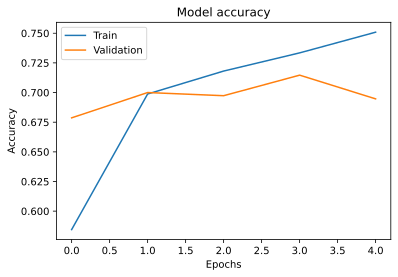

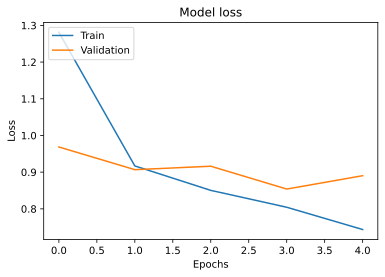

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
loss,█▃▂▂▁
val_accuracy,▁▅▅█▄
val_loss,█▄▅▁▃
accuracy,0.75089
best_epoch,3
best_val_loss,0.85397
epoch,4
loss,0.74362
val_accuracy,0.69467


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gxdx6pxg with config:
wandb: 	batch_size: 256
wandb: 	data_augmentation: False
wandb: 	dense_layer: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	pre_layer_train: None


pre_train_mdl_Xception_aug_False_bs_256_ep_10_dropout_0.1_dense_128
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
33707954
Epoch 1/10
36/36 - 263s - loss: 3.6631 - accuracy: 0.4167 - val_loss: 1.2481 - val_accuracy: 0.5813 - _timestamp: 1648130934.0000 - _runtime: 279.0000 - 263s/epoch - 7s/step
Epoch 2/10
36/36 - 253s - loss: 1.2462 - accuracy: 0.5940 - val_loss: 1.1016 - val_accuracy: 0.6333 - _timestamp: 1648131187.0000 - _runtime: 532.0000 - 253s/epoch - 7s/step
Epoch 3/10
36/36 - 255s - loss: 1.0869 - accuracy: 0.6467 - val_loss: 1.0151 - val_accuracy: 0.6413 - _timestamp: 1648131442.0000 - _runtime: 787.0000 - 255s/epoch - 7s/step
Epoch 4/10
36/36 - 253s - loss: 1.0341 - accuracy: 0.6627 - val_loss: 1.0272 - val_accuracy: 0.6840 - _timestamp: 1648131696.0000 - _runtime: 1041.0000 - 253s/epoch - 7s/step
Epoch 5/10
36/36 - 249s - loss: 0.9858 - accuracy: 0.6739 - val_loss: 0.9753 - val_accuracy: 0.662

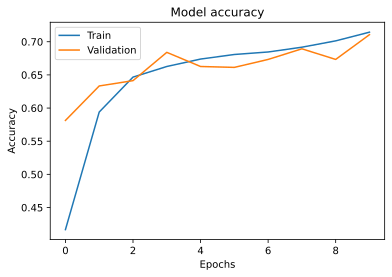

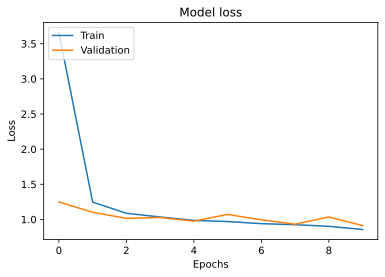

accuracy,▁▅▆▇▇▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▁▁▁▁▁▁▁
val_accuracy,▁▄▄▇▅▅▆▇▆█
val_loss,█▅▃▃▂▄▃▁▄▁
accuracy,0.71444
best_epoch,9
best_val_loss,0.91126
epoch,9
loss,0.85581
val_accuracy,0.71067


wandb: Agent Starting Run: tlznkrzl with config:
wandb: 	batch_size: 256
wandb: 	data_augmentation: True
wandb: 	dense_layer: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	pre_layer_train: 10


pre_train_mdl_Xception_aug_True_bs_256_ep_5_dropout_0.2_dense_256
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
46554418
Epoch 1/5
36/36 - 263s - loss: 2.5858 - accuracy: 0.4539 - val_loss: 1.5003 - val_accuracy: 0.6253 - _timestamp: 1648133503.0000 - _runtime: 278.0000 - 263s/epoch - 7s/step
Epoch 2/5
36/36 - 247s - loss: 1.0949 - accuracy: 0.6524 - val_loss: 1.6115 - val_accuracy: 0.6253 - _timestamp: 1648133754.0000 - _runtime: 529.0000 - 247s/epoch - 7s/step
Epoch 3/5
36/36 - 248s - loss: 0.8929 - accuracy: 0.7089 - val_loss: 0.9254 - val_accuracy: 0.7040 - _timestamp: 1648133998.0000 - _runtime: 773.0000 - 248s/epoch - 7s/step
Epoch 4/5
36/36 - 249s - loss: 0.7551 - accuracy: 0.7476 - val_loss: 0.9386 - val_accuracy: 0.6907 - _timestamp: 1648134251.0000 - _runtime: 1026.0000 - 249s/epoch - 7s/step
Epoch 5/5
36/36 - 258s - loss: 0.6752 - accuracy: 0.7741 - val_loss: 0.8640 - val_accuracy: 0.7213 - _ti

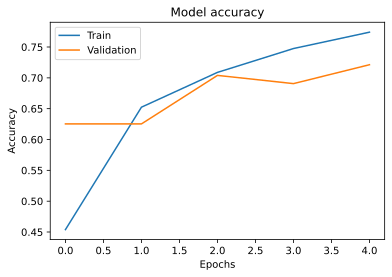

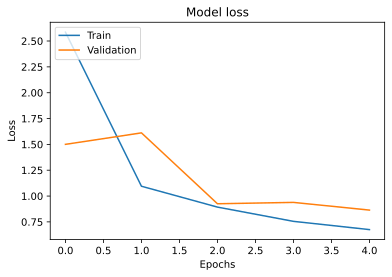

accuracy,▁▅▇▇█
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▁▇▆█
val_loss,▇█▂▂▁
accuracy,0.77411
best_epoch,4
best_val_loss,0.86399
epoch,4
loss,0.67521
val_accuracy,0.72133


In [7]:
# Sweep configuration
sweep_config = {
  "name": "CNN_part B",
  "metric": {
      "name":"val_accuracy",
      "goal": "maximize"
  },
  "method": "bayes",
  "parameters": {
        "data_augmentation": {
            "values": [True, False]
        },
        "batch_size": {
            "values": [128, 256]
        },
        "learning_rate": {
            "values": [0.001, 0.0001]
        },
        "epochs": {
            "values": [5, 10]
        },
        "dropout": {
            "values": [0, 0.2, 0.1]
        },
        "dense_layer": {
            "values": [128, 256, 512]
        },
                "pre_layer_train": {
            "values": [None, 10, 20]
        }
           }
}

# Generates a sweep id
sweep_id = wandb.sweep(sweep_config, entity="moni6264", project="part_b_xception")
wandb.agent(sweep_id, train, count=3)